In [1]:
from cntools.datasets import Dataset
from general import cns_remap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import os
sys.path.insert(0, '..')
plt.rcParams["font.family"] = 'Arial'

In [2]:
def cal_heatmap(ds, cns, n_cns, index=None, excluded_cells=[]):
    label_counts = np.zeros((n_cns, ds.n_cts))
    tissue_avgs = np.zeros(ds.n_cts)
    for sample in ds.data:
        for image in ds.data[sample]:
            for i, freq in enumerate(ds.data[sample][image].cts_oh):
                label_counts[cns[sample][image][i]] += freq
                tissue_avgs += freq
    #
    label_counts = label_counts[:, [i for i in range(len(ds.ct_order)) if ds.ct_order[i] not in excluded_cells]]
    tissue_avgs = tissue_avgs[[i for i in range(len(ds.ct_order)) if ds.ct_order[i] not in excluded_cells]]

    tissue_avgs /= tissue_avgs.sum()

    fc = np.log2(((label_counts + tissue_avgs) / (label_counts + tissue_avgs).sum(axis=1, keepdims=True)) / tissue_avgs)
    print(fc.max(), fc.min())
    if index:
        fc = pd.DataFrame(fc, columns=[ct for ct in ds.ct_order if ct not in excluded_cells], index=index)
    else:
        fc = pd.DataFrame(fc, columns=[ct for ct in ds.ct_order if ct not in excluded_cells], index=[f'CN-{i+1}' for i in range(n_cns)])

    cn_freq = label_counts / label_counts.sum(axis=1, keepdims=True)
    cn_cell_freq = label_counts.sum(axis=1) / label_counts.sum()

    return fc, cn_freq, cn_cell_freq

In [3]:
def draw_heatmap_crc(ds, cns, n_cns, filename=None, index=None, title=None, ax=None, cbar=True, cbar_ax=None, vert=False, is_top=False, is_bottom=False, color_cn=False, excluded_cells=[]):
    fc, cn_freq, cn_cell_freq = cal_heatmap(ds, cns, n_cns, index, excluded_cells)
    if not vert:
        plt.figure(figsize=(10, 5))
        sns.heatmap(fc, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'}) # cbar_kws={'label': 'Enrichment score'}, 'pad': 0.08
    else:
        plt.figure(figsize=(5, 10))
        sns.heatmap(fc.T, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical'}) # cbar_kws={'label': 'Enrichment score'}
    
    matx, maty = np.zeros((n_cns, ds.n_cts)), np.zeros((n_cns, ds.n_cts))
    for i in range(len(matx)):
        matx[i] += i
    for j in range(len(matx[0])):
        maty[:, j] += j
    if not vert:
        scatter = ax.scatter(0.5 + maty, 0.5 + matx, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))
        if is_top:
            ax.annotate('Cell%', (-1.9, -0.4), annotation_clip=False)
            ax.annotate('CN', (ds.n_cts + .5, -0.4), annotation_clip=False)
            cbar_ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
            cbar_ax.set_title('CN Enrichment Score')
        if is_bottom:
            ax.annotate('CT:', (-3, n_cns + 1), annotation_clip=False)
        else:
            ax.get_xaxis().set_visible(False)
            ax.get_legend().remove()

        ax.tick_params(axis='y', pad=23)
        if title:
            ax.set_title(title, rotation='vertical', x=-0.08, y=0.5, ha='right', va='center')

        alpha_list = [(i - min(cn_cell_freq)) / (max(cn_cell_freq) - min(cn_cell_freq)) * 0.75 + 0.25 for i in cn_cell_freq] 
        for i, (x, y) in enumerate(zip(np.ones(len(cn_cell_freq)) * 0 - 1.9, 0.8 + np.arange(len(cn_cell_freq)))):
            ax.annotate(round(cn_cell_freq[i], 3), (x, y), annotation_clip=False, alpha=alpha_list[i])
    else:
        scatter = ax.scatter(0.5 + matx, 0.5 + maty, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))
    
    # plt.setp(legend.get_title(), multialignment='center')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=30 if vert else 45, ha='right')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    for i in range(1, n_cns + 1):
        if color_cn:
            ax.annotate(f'{i}', (ds.n_cts + 0.8, i - 0.25), bbox={'boxstyle' : 'circle', 'color': sns.color_palette('bright')[i-1], 'pad': 0.05, 'alpha': 0.8}, annotation_clip=False, size=10)
        else:
            ax.annotate(f'{i}', (ds.n_cts + 0.8, i - 0.25), bbox={'boxstyle' : 'circle', 'color': sns.color_palette('bright')[i-1], 'pad': 0.05, 'alpha': 0}, annotation_clip=False, size=10)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    
    return ax

In [4]:
def draw_heatmap_t2d(ds, cns, n_cns, filename=None, index=None, title=None, ax=None, cbar=True, cbar_ax=None, vert=False, is_top=False, is_bottom=False, color_cn=False, excluded_cells=[]):
    fc, cn_freq, cn_cell_freq = cal_heatmap(ds, cns, n_cns, index, excluded_cells)
    if not vert:
        plt.figure(figsize=(10, 5))
        sns.heatmap(fc, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'}) # cbar_kws={'label': 'Enrichment score'}, 'pad': 0.08
    else:
        plt.figure(figsize=(5, 10))
        sns.heatmap(fc.T, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical'}) # cbar_kws={'label': 'Enrichment score'}

    matx, maty = np.zeros((n_cns, ds.n_cts)), np.zeros((n_cns, ds.n_cts))
    for i in range(len(matx)):
        matx[i] += i
    for j in range(len(matx[0])):
        maty[:, j] += j
    if not vert:
        scatter = ax.scatter(0.5 + maty, 0.5 + matx, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))
        if is_top:
            ax.annotate('Cell%', (-1.4, -0.4), annotation_clip=False)
            ax.annotate('CN', (ds.n_cts + 0.4, -0.4), annotation_clip=False)
            cbar_ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
            cbar_ax.set_title('CN Enrichment Score')
        if is_bottom:
            ax.annotate('CT:', (-2.3, n_cns + 1), annotation_clip=False)
        else:
            ax.get_xaxis().set_visible(False)
            ax.get_legend().remove()
    
        ax.tick_params(axis='y', pad=23)
        if title:
            ax.set_title(title, rotation='vertical', x=-0.17, y=0.5, ha='right', va='center')
    
        alpha_list = [(i - min(cn_cell_freq)) / (max(cn_cell_freq) - min(cn_cell_freq)) * 0.75 + 0.25 for i in cn_cell_freq] 
        for i, (x, y) in enumerate(zip(np.ones(len(cn_cell_freq)) * 0 - 1.4, 0.7 + np.arange(len(cn_cell_freq)))):
            ax.annotate(round(cn_cell_freq[i], 3), (x, y), annotation_clip=False, alpha=alpha_list[i])
    else:
        scatter = ax.scatter(0.5 + matx, 0.5 + maty, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))

    # plt.setp(legend.get_title(), multialignment='center')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=30 if vert else 45, ha='right')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    for i in range(1, n_cns + 1):
        if color_cn:
            ax.annotate(f'{i}', (ds.n_cts + 0.6, i - 0.35), bbox={'boxstyle' : 'circle', 'color': sns.color_palette('bright')[i-1], 'pad': 0.05, 'alpha': 0.8}, annotation_clip=False, size=10)
        else:
            ax.annotate(f'{i}', (ds.n_cts + 0.6, i - 0.35), bbox={'boxstyle' : 'circle', 'color': sns.color_palette('bright')[i-1], 'pad': 0.05, 'alpha': 0}, annotation_clip=False, size=10)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    
    return ax

In [5]:
def draw_heatmap_hlt(ds, cns, n_cns, filename=None, index=None, title=None, ax=None, cbar=True, cbar_ax=None, vert=False, is_top=False, is_bottom=False, color_cn=False, excluded_cells=[]):
    fc, cn_freq, cn_cell_freq = cal_heatmap(ds, cns, n_cns, index, excluded_cells)
    if not vert:
        plt.figure(figsize=(10, 5))
        sns.heatmap(fc, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'}) # cbar_kws={'label': 'Enrichment score'}, 'pad': 0.08
    else:
        plt.figure(figsize=(5, 10))
        sns.heatmap(fc.T, vmin=-4, vmax=4, cmap='bwr', linewidths=0.5, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical'}) # cbar_kws={'label': 'Enrichment score'}
    
    matx, maty = np.zeros((n_cns, ds.n_cts - len(excluded_cells))), np.zeros((n_cns, ds.n_cts - len(excluded_cells)))
    for i in range(len(matx)):
        matx[i] += i
    for j in range(len(matx[0])):
        maty[:, j] += j
    if not vert:
        scatter = ax.scatter(0.5 + maty, 0.5 + matx, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))
        if is_top:
            ax.annotate('Cell%', (-1.6, -0.4), annotation_clip=False)
            ax.annotate('CN', (ds.n_cts - len(excluded_cells) + .5, -0.4), annotation_clip=False)
            cbar_ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
            cbar_ax.set_title('CN Enrichment Score')
        if is_bottom:
            ax.annotate('CT:', (-2.5, n_cns + 1), annotation_clip=False)
        else:
            ax.get_xaxis().set_visible(False)
            ax.get_legend().remove()

        ax.tick_params(axis='y', pad=23)
        if title:
            ax.set_title(title, rotation='vertical', x=-0.08, y=0.5, ha='right', va='center')

        alpha_list = [(i - min(cn_cell_freq)) / (max(cn_cell_freq) - min(cn_cell_freq)) * 0.75 + 0.25 for i in cn_cell_freq] 
        for i, (x, y) in enumerate(zip(np.ones(len(cn_cell_freq)) * 0 - 1.6, 0.8 + np.arange(len(cn_cell_freq)))):
            ax.annotate(round(cn_cell_freq[i], 3), (x, y), annotation_clip=False, alpha=alpha_list[i])
    else:
        scatter = ax.scatter(0.5 + matx, 0.5 + maty, marker='o', s=cn_freq * 60, color='black')
        legend = ax.legend(*scatter.legend_elements(**dict(prop='sizes', num=4, func=lambda s: s/60)), title=f'CT frequency per CN', loc='upper left', frameon=False, edgecolor='k', bbox_to_anchor=(1, 0))
    
    # plt.setp(legend.get_title(), multialignment='center')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=30 if vert else 45, ha='right')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    for i in range(1, n_cns + 1):
        if color_cn:
            ax.annotate(f'{i}', (ds.n_cts - len(excluded_cells) + 0.8, i - 0.2), bbox={'boxstyle' : 'circle', 'color': (sns.color_palette('bright') + [(0.4,0.4,0.4)])[i-1], 'pad': 0.05, 'alpha': 0.8}, annotation_clip=False, size=10, ha='center')
        else:
            ax.annotate(f'{i}', (ds.n_cts - len(excluded_cells) + 0.8, i - 0.2), bbox={'boxstyle' : 'circle', 'color': (sns.color_palette('bright') + [(0.0,0.0,0.0)])[i-1], 'pad': 0.05, 'alpha': 0}, annotation_clip=False, size=10, ha='center')
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    
    return ax

3.6431081360994506 -14.959911398665216
3.6431081360994506 -14.959911398665216
5.552203384964647 -15.363108093658633
3.6431081360994506 -14.959911398665216
6.166458661075399 -15.430158494177496
3.6431081360994506 -14.959911398665216
5.563315810734172 -15.392585756275468
3.6431081360994506 -14.959911398665216
4.09866283471878 -15.67920516953017
3.6431081360994506 -14.959911398665216
3.5757470800659212 -14.466076461396252
3.6431081360994506 -14.959911398665216
2.3847668113618057 -15.2625720423857


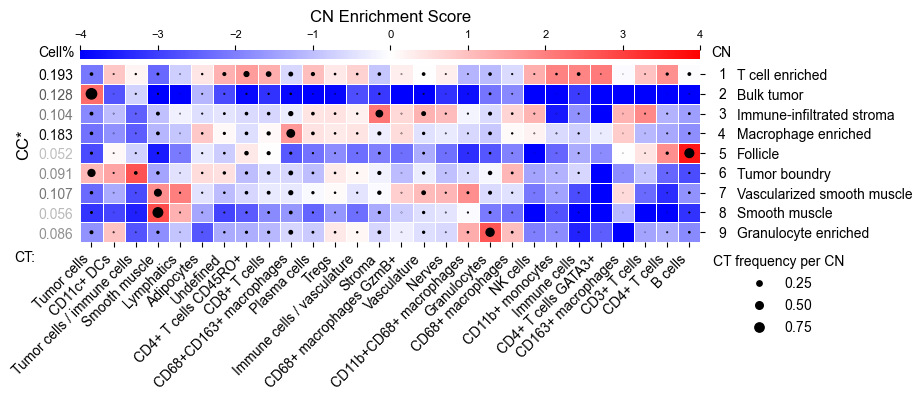

<Figure size 1000x500 with 0 Axes>

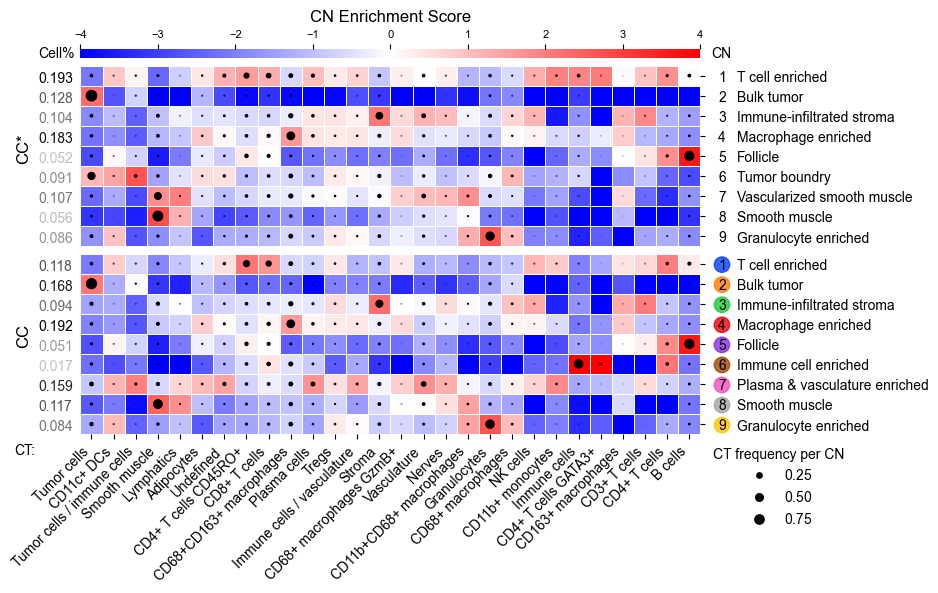

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

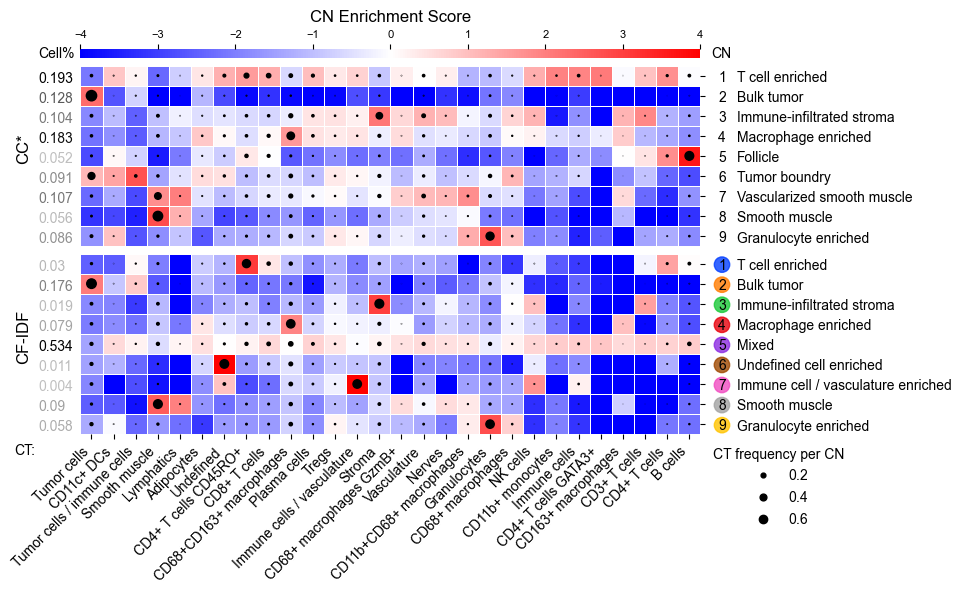

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

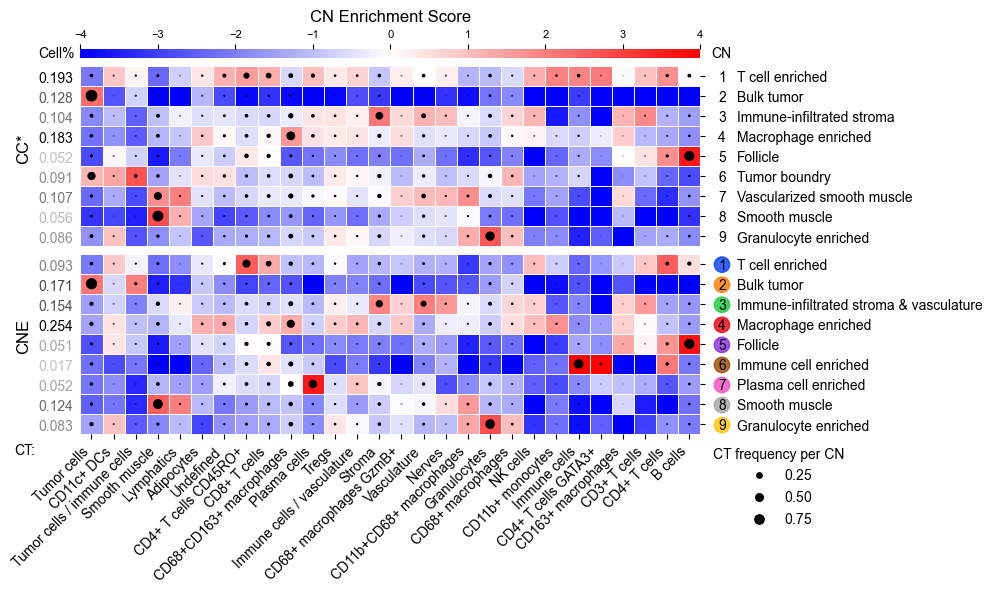

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

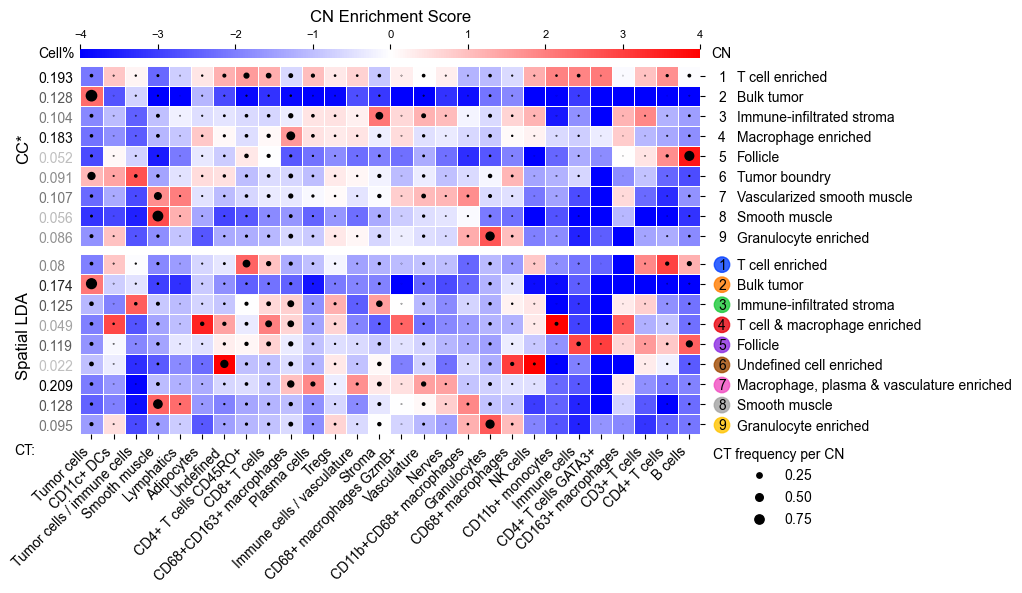

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

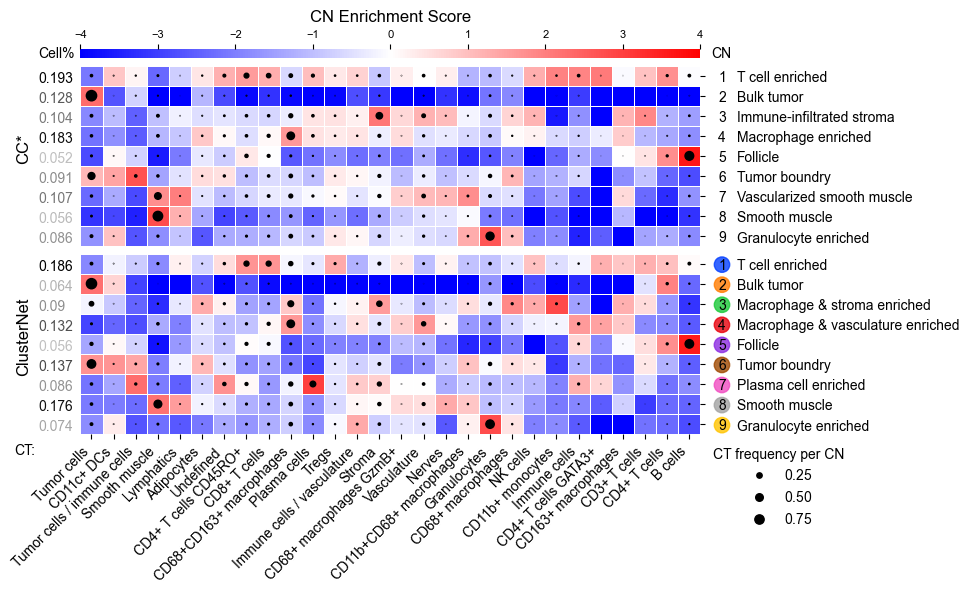

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

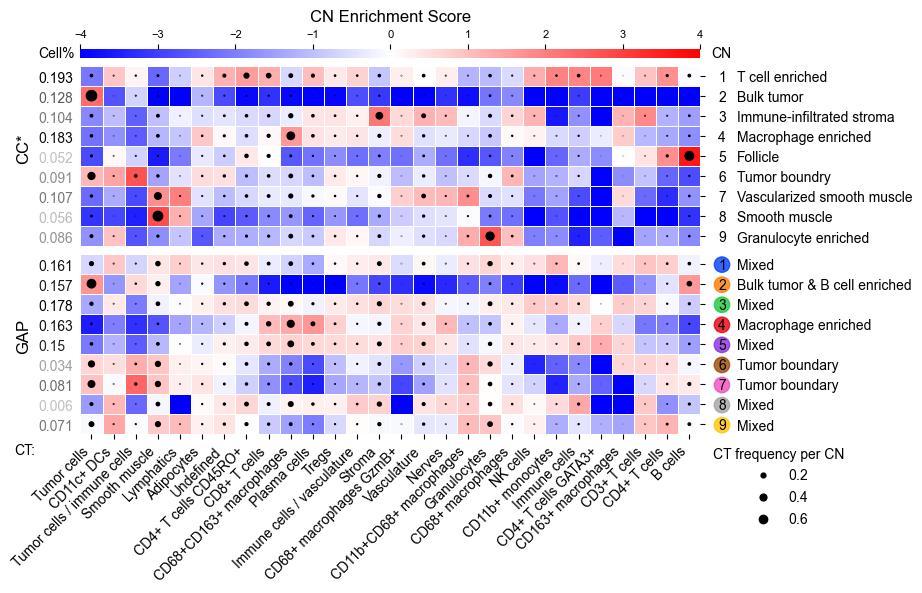

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [6]:
# CRC:

n_cns = 9
cns, ind = {}, {}

ds_ori = pickle.load(open('../data/CRC/CRC_ds_ori_nodirt.pkl', 'rb'))

cns['CC_ori'] = pickle.load(open('../cn/CRC/CC_ori/cns_nodirt.pkl', 'rb'))
ind['CC_ori'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Tumor boundry', 'CN-7: Vascularized smooth muscle', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

ds = pickle.load(open('../data/CRC/CRC_ds.pkl', 'rb'))

cns['CC'] = cns_remap(pickle.load(open('../cn/CRC/CC/cns_n_cns=9_m=10_naive.pkl', 'rb')), [1, 2, 6, 4, 7, 5, 3, 8, 0])
ind['CC'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Plasma & vasculature enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CF-IDF'] = cns_remap(pickle.load(open('../cn/CRC/CF-IDF/cns_n_cns=9_eps=32_r=0.8_naive.pkl', 'rb')), [3, 4, 7, 8, 0, 5, 6, 2, 1])
ind['CF-IDF'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma', 'CN-4: Macrophage enriched', 'CN-5: Mixed', 'CN-6: Undefined cell enriched', 'CN-7: Immune cell / vasculature enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CNE'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=15_lam=0.25_naive.pkl', 'rb')), [2, 3, 7, 1, 8, 5, 6, 0, 4])
ind['CNE'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Plasma cell enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['Spatial LDA'] = cns_remap(pickle.load(open('../cn/CRC/Spatial LDA/cns_n_cns=9_eps=50_b=0.025_naive.pkl', 'rb')), [8, 2, 4, 0, 7, 6, 5, 3, 1])
ind['Spatial LDA'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma', 'CN-4: T cell & macrophage enriched', 'CN-5: Follicle', 'CN-6: Undefined cell enriched', 'CN-7: Macrophage, plasma & vasculature enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['ClusterNet'] = cns_remap(pickle.load(open('../cn/CRC/ClusterNet/6first_16_70.0_naive.pkl', 'rb')), [8, 1, 3, 5, 0, 4, 2, 7, 6])
ind['ClusterNet'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Macrophage & stroma enriched', 'CN-4: Macrophage & vasculature enriched', 'CN-5: Follicle', 'CN-6: Tumor boundry', 'CN-7: Plasma cell enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['GAP'] = cns_remap(pickle.load(open('../cn/CRC/GAP/6first_labels_naive.pkl', 'rb')), [3, 0, 5, 2, 7, 6, 8, 1, 4])
ind['GAP'] = ['CN-1: Mixed', 'CN-2: Bulk tumor & B cell enriched', 'CN-3: Mixed', 'CN-4: Macrophage enriched', 'CN-5: Mixed', 'CN-6: Tumor boundary', 'CN-7: Tumor boundary', 'CN-8: Mixed', 'CN-9: Mixed']

ind = {method: [i.split(': ')[1] for i in ind_cn] for method, ind_cn in ind.items()}

out_dir = f'../analysis_res/CRC'
for method in cns:
    if method[-3:] != 'ori':
        fig, axes = plt.subplots(3, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_crc(ds_ori, cns['CC_ori'], n_cns, index=ind['CC_ori'], title='CC*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True, excluded_cells=['Dirt'])
        draw_heatmap_crc(ds, cns[method], n_cns, index=ind[method], title=method, cbar=False, ax=axes[2], is_bottom=True, color_cn=True)
    else:
        fig, axes = plt.subplots(2, 1, figsize=(8, 2.5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_crc(ds_ori, cns['CC_ori'], n_cns, index=ind['CC_ori'], title='CC*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True, is_bottom=True, excluded_cells=['Dirt'])
    os.makedirs(f'{out_dir}/{method}', exist_ok=True)
    fig.savefig(f'{out_dir}/{method}/enrich.pdf', bbox_inches='tight')

5.568890147379447 -15.346063513260846
6.575188004913983 -15.322033757158632
5.563315810734172 -15.392585756275468
6.567016187272427 -15.340997524218473
6.555387387904316 -15.351008221579027


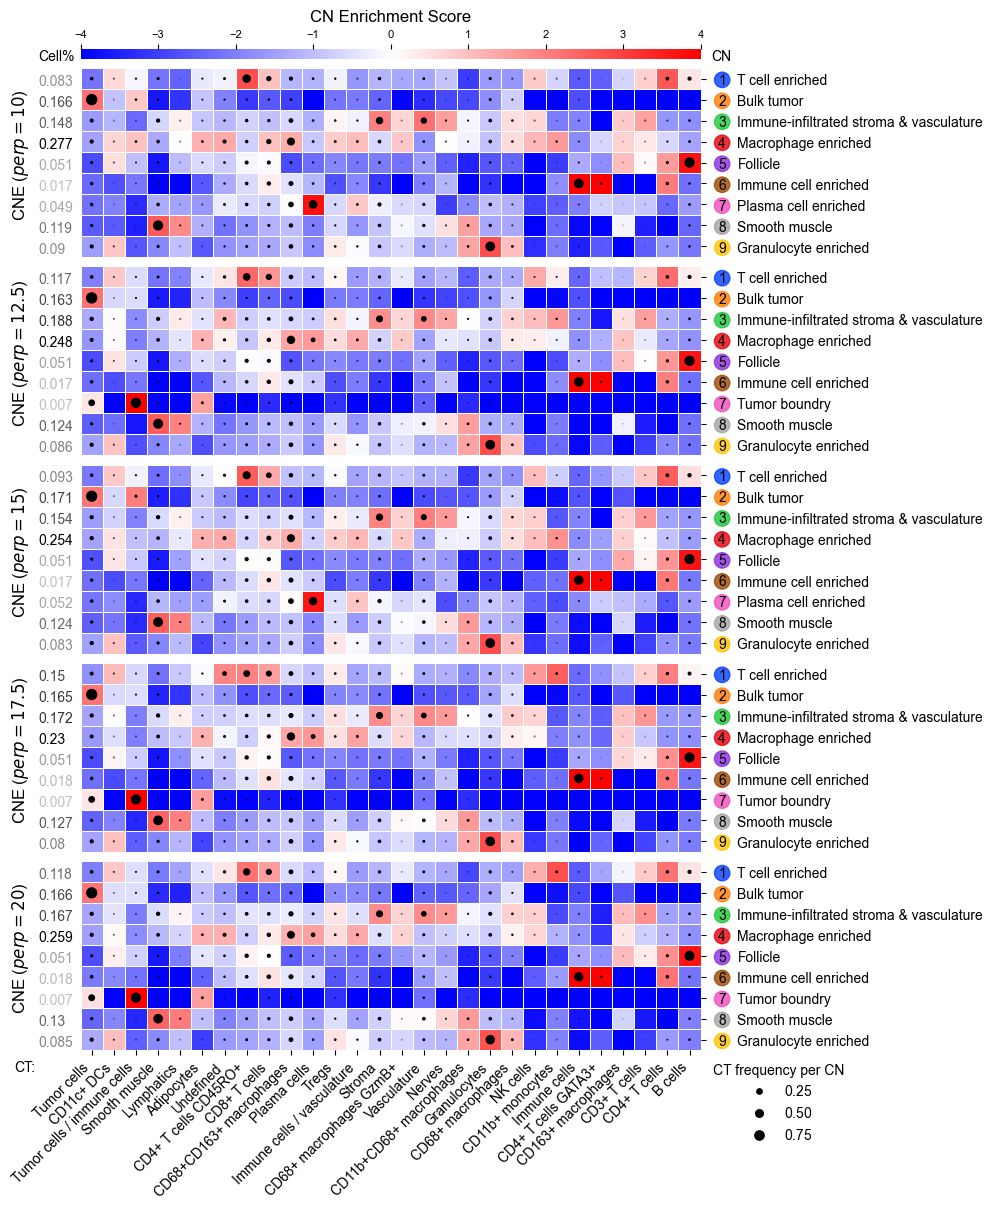

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Sensitive analysis of CNE on CRC :

n_cns = 9
cns, ind = {}, {}

ds = pickle.load(open('../data/CRC/CRC_ds.pkl', 'rb'))

cns['CNE ($perp=10$)'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=10_lam=0.25_naive.pkl', 'rb')), [8, 1, 3, 7, 4, 0, 2, 6, 5])
ind['CNE ($perp=10$)'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Plasma cell enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CNE ($perp=12.5$)'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=12.5_lam=0.25_naive.pkl', 'rb')), [2, 3, 6, 8, 0, 7, 4, 1, 5])
ind['CNE ($perp=12.5$)'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Tumor boundry', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CNE ($perp=15$)'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=15_lam=0.25_naive.pkl', 'rb')), [2, 3, 7, 1, 8, 5, 6, 0, 4])
ind['CNE ($perp=15$)'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Plasma cell enriched', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CNE ($perp=17.5$)'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=17.5_lam=0.25_naive.pkl', 'rb')), [0, 3, 7, 6, 4, 5, 1, 8, 2])
ind['CNE ($perp=17.5$)'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Tumor boundry', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

cns['CNE ($perp=20$)'] = cns_remap(pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=20_lam=0.25_naive.pkl', 'rb')), [7, 8, 5, 1, 2, 0, 3, 6, 4])
ind['CNE ($perp=20$)'] = ['CN-1: T cell enriched', 'CN-2: Bulk tumor', 'CN-3: Immune-infiltrated stroma & vasculature', 'CN-4: Macrophage enriched', 'CN-5: Follicle', 'CN-6: Immune cell enriched', 'CN-7: Tumor boundry', 'CN-8: Smooth muscle', 'CN-9: Granulocyte enriched']

ind = {method: [i.split(': ')[1] for i in ind_cn] for method, ind_cn in ind.items()}

out_dir = f'../analysis_res/CRC'
fig, axes = plt.subplots(6, 1, figsize=(8, 13), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1, 1, 1, 1, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
for i, method in enumerate(cns):
    if i == 0:
        draw_heatmap_crc(ds, cns[method], n_cns, index=ind[method], title=method, cbar=True, ax=axes[i+1], cbar_ax=axes[i], is_top=True, color_cn=True)
    elif i == len(cns) - 1:
        draw_heatmap_crc(ds, cns[method], n_cns, index=ind[method], title=method, cbar=False, ax=axes[i+1], is_bottom=True, color_cn=True)
    else:
        draw_heatmap_crc(ds, cns[method], n_cns, index=ind[method], title=method, cbar=False, ax=axes[i+1], color_cn=True)

os.makedirs(f'{out_dir}/CNE', exist_ok=True)
fig.savefig(f'{out_dir}/CNE/enrich_sens.pdf', bbox_inches='tight')

4.566580204138871 -12.606405212697785
4.566580204138871 -12.606405212697785
2.8842828556199347 -13.488342277532524
4.566580204138871 -12.606405212697785
6.758873667801873 -12.144976824050111
4.566580204138871 -12.606405212697785
4.9863045957532055 -10.430452551665532
4.566580204138871 -12.606405212697785
5.2133045846108415 -8.654636028527968
4.566580204138871 -12.606405212697785
2.3764281269439786 -12.92629599478111
4.566580204138871 -12.606405212697785
4.149526383759611 -8.43879185257826


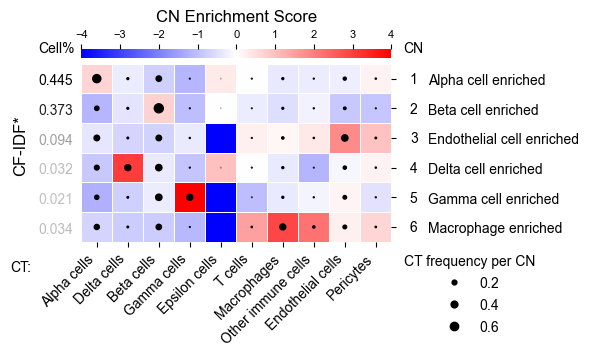

<Figure size 1000x500 with 0 Axes>

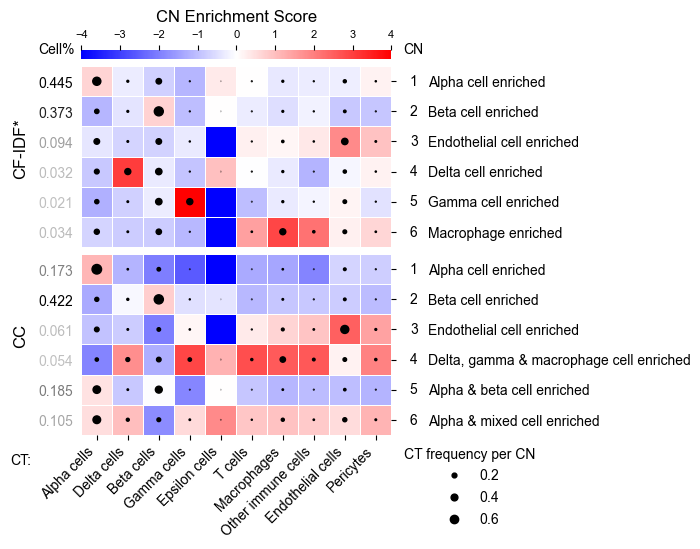

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

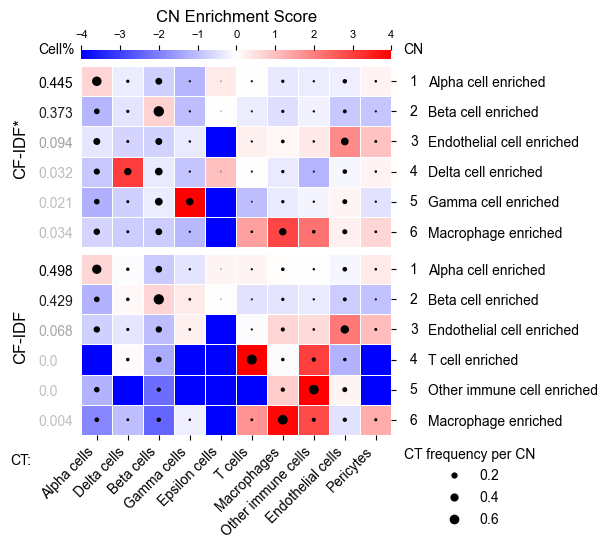

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

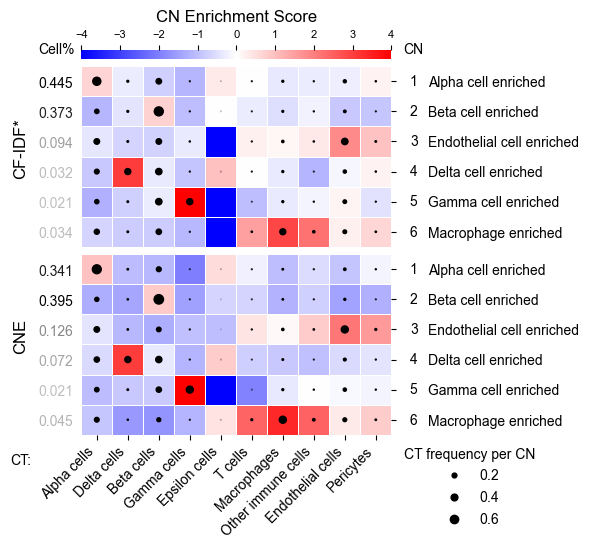

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

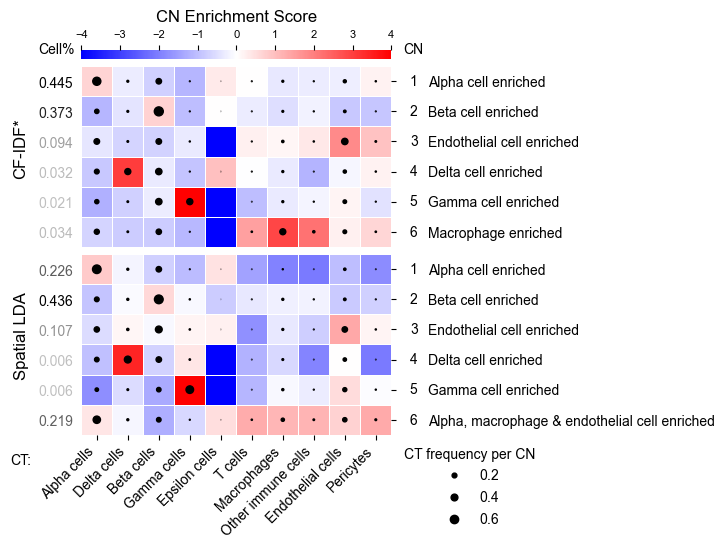

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

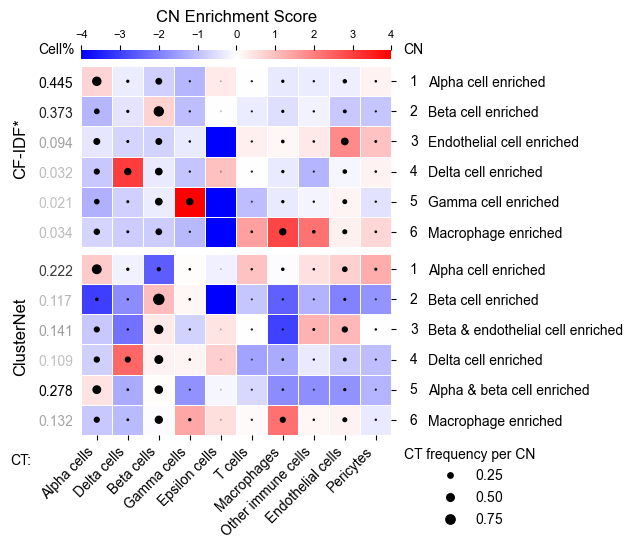

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

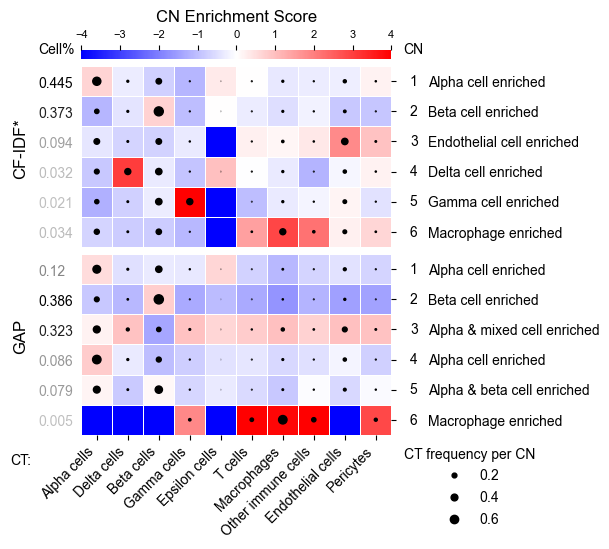

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [7]:
# T2D:

n_cns = 6
cns, ind = {}, {}

ds_ori = pickle.load(open('../data/T2D/T2D_ds.pkl', 'rb'))

cns['CF-IDF_ori'] = pickle.load(open('../cn/T2D/CF-IDF_ori/cns.pkl', 'rb'))
ind['CF-IDF_ori'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Endothelial cell enriched', 'CN-4: Delta cell enriched', 'CN-5: Gamma cell enriched', 'CN-6: Macrophage enriched']

ds = ds_ori

cns['CC'] = cns_remap(pickle.load(open('../cn/T2D/CC/cns_n_cns=6_m=5_hmrf.pkl', 'rb')), [1, 4, 0, 2, 5, 3])
ind['CC'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Endothelial cell enriched', 'CN-4: Delta, gamma & macrophage cell enriched', 'CN-5: Alpha & beta cell enriched', 'CN-6: Alpha & mixed cell enriched']

cns['CF-IDF'] = cns_remap(pickle.load(open('../cn/T2D/CF-IDF/cns_n_cns=6_eps=57_r=0.5_naive.pkl', 'rb')), [0, 1, 5, 3, 4, 2])
ind['CF-IDF'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Endothelial cell enriched', 'CN-4: T cell enriched', 'CN-5: Other immune cell enriched', 'CN-6: Macrophage enriched']

cns['CNE'] = cns_remap(pickle.load(open('../cn/T2D/CNE/cns_n_cns=6_perp=15_lam=0.25_naive.pkl', 'rb')), [3, 1, 4, 2, 0, 5])
ind['CNE'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Endothelial cell enriched', 'CN-4: Delta cell enriched', 'CN-5: Gamma cell enriched', 'CN-6: Macrophage enriched']

cns['Spatial LDA'] = cns_remap(pickle.load(open('../cn/T2D/Spatial LDA/cns_n_cns=6_eps=100_b=0.25_naive.pkl', 'rb')), [2, 1, 0, 4, 3, 5])
ind['Spatial LDA'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Endothelial cell enriched', 'CN-4: Delta cell enriched', 'CN-5: Gamma cell enriched', 'CN-6: Alpha, macrophage & endothelial cell enriched']

cns['ClusterNet'] = cns_remap(pickle.load(open('../cn/T2D/ClusterNet/6first_16_70.0_hmrf.pkl', 'rb')), [1, 2, 0, 3, 5, 4])
ind['ClusterNet'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Beta & endothelial cell enriched', 'CN-4: Delta cell enriched', 'CN-5: Alpha & beta cell enriched', 'CN-6: Macrophage enriched']

cns['GAP'] = cns_remap(pickle.load(open('../cn/T2D/GAP/6first_labels_hmrf.pkl', 'rb')), [0, 2, 4, 5, 3, 1])
ind['GAP'] = ['CN-1: Alpha cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Alpha & mixed cell enriched', 'CN-4: Alpha cell enriched', 'CN-5: Alpha & beta cell enriched', 'CN-6: Macrophage enriched']

ind = {method: [i.split(': ')[1] for i in ind_cn] for method, ind_cn in ind.items()}

out_dir = f'../analysis_res/T2D'
for method in cns:
    if method[-3:] != 'ori':
        fig, axes = plt.subplots(3, 1, figsize=(4, 5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_t2d(ds_ori, cns['CF-IDF_ori'], n_cns, index=ind['CF-IDF_ori'], title='CF-IDF*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True)
        draw_heatmap_t2d(ds, cns[method], n_cns, index=ind[method], title=method, cbar=False, ax=axes[2], is_bottom=True)
    else:
        fig, axes = plt.subplots(2, 1, figsize=(4, 2.5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_t2d(ds_ori, cns['CF-IDF_ori'], n_cns, index=ind['CF-IDF_ori'], title='CF-IDF*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True, is_bottom=True)
    os.makedirs(f'{out_dir}/{method}', exist_ok=True)
    fig.savefig(f'{out_dir}/{method}/enrich.pdf', bbox_inches='tight')

CC_ori
4.564294317766675 -16.842055645212213
CC
4.564294317766675 -16.842055645212213
4.2072832142630805 -16.808159772868375
CF-IDF
4.564294317766675 -16.842055645212213
4.819379581277306 -13.027042055565033
CNE
4.564294317766675 -16.842055645212213
4.578940832030761 -17.083437774456915


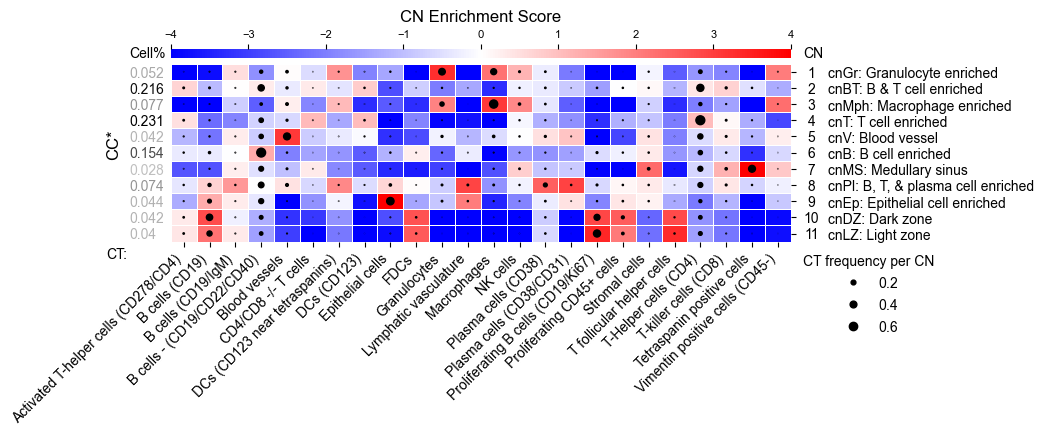

<Figure size 1000x500 with 0 Axes>

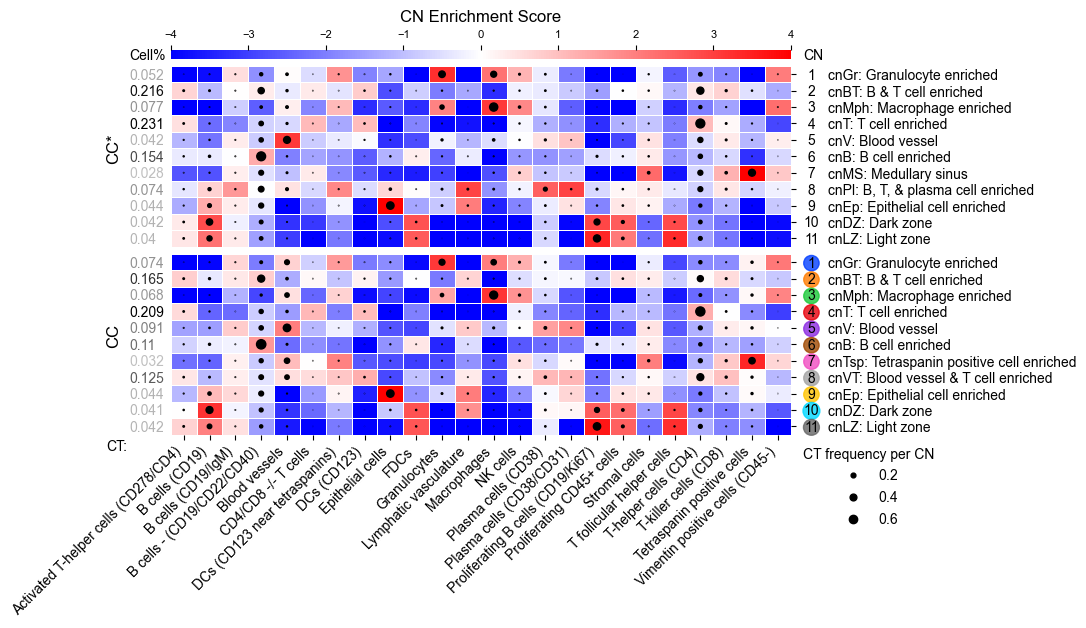

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

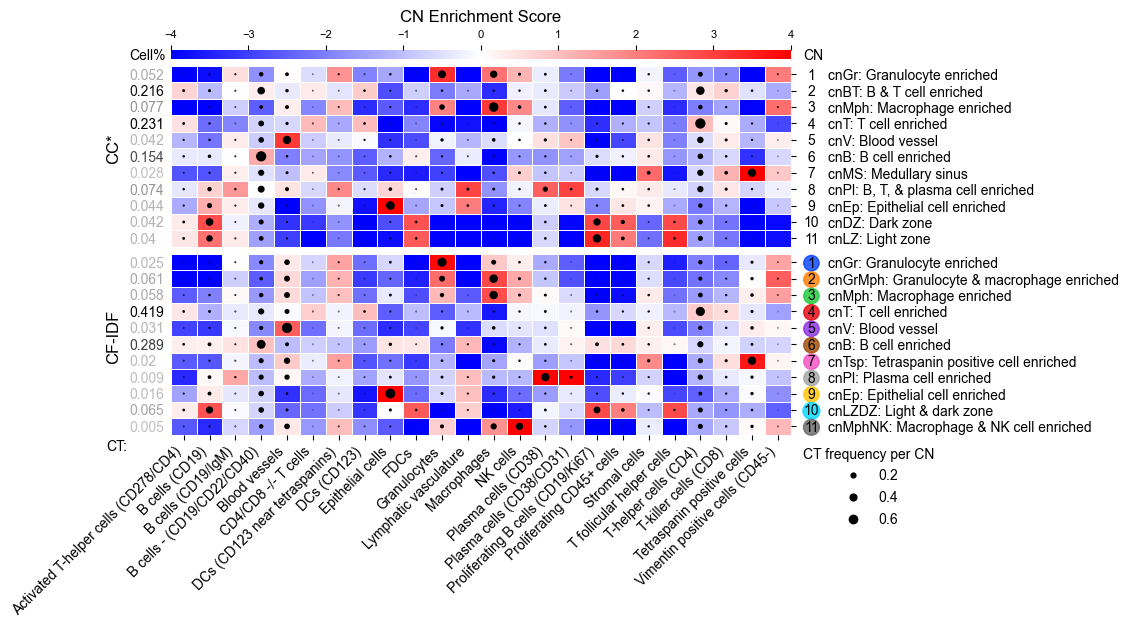

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

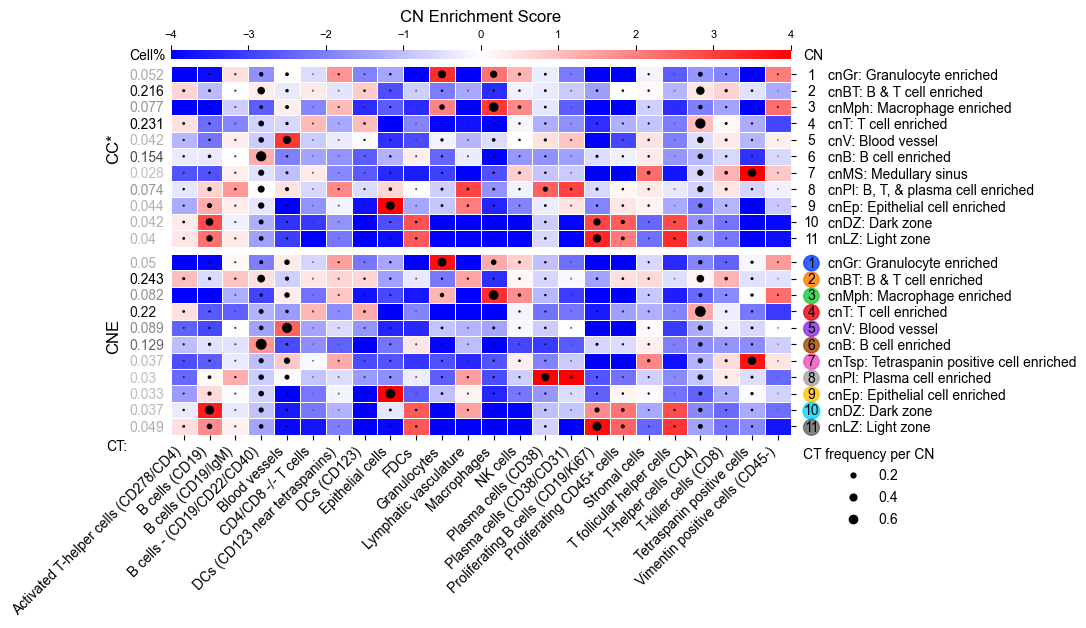

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [120]:
# HLT

n_cns = 11
cns, ind = {}, {}

ds_ori = pickle.load(open('../data/HLT/HLT_ds_ori.pkl', 'rb'))

cns['CC_ori'] = cns_remap(pickle.load(open('../cn/HLT/CC_ori/cns.pkl', 'rb')), [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 9])
ind['CC_ori'] = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnMS: Medullary sinus', 'cnPl: B, T, & plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']

ds = pickle.load(open('../data/HLT/HLT_ds.pkl', 'rb'))

cns['CC'] = cns_remap(pickle.load(open('../cn/HLT/CC/cns_n_cns=11_m=20_naive.pkl', 'rb')), [6, 1, 3, 2, 9, 5, 0, 8, 4, 10, 7])
ind['CC'] = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnVT: Blood vessel & T cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']

cns['CF-IDF'] = cns_remap(pickle.load(open('../cn/HLT/CF-IDF/cns_n_cns=11_eps=23_r=0.8_naive.pkl', 'rb')), [2, 9, 10, 3, 8, 4, 5, 0, 7, 6, 1])
ind['CF-IDF'] = ['cnGr: Granulocyte enriched', 'cnGrMph: Granulocyte & macrophage enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnLZDZ: Light & dark zone', 'cnMphNK: Macrophage & NK cell enriched']

cns['CNE'] = cns_remap(pickle.load(open('../cn/HLT/CNE/cns_n_cns=11_perp=15_lam=0.25_naive.pkl', 'rb')), [1, 6, 2, 8, 9, 4, 7, 5, 3, 10, 0])
ind['CNE'] = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']

# ind = {method: [i.split(': ')[1] for i in ind_cn] for method, ind_cn in ind.items()}

out_dir = f'../analysis_res/HLT'
for method in cns:
    print(method)
    if method[-3:] != 'ori':
        fig, axes = plt.subplots(3, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_hlt(ds_ori, cns['CC_ori'], n_cns, index=ind['CC_ori'], title='CC*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True, excluded_cells=['ECM'])
        draw_heatmap_hlt(ds, cns[method], n_cns, index=ind[method], title=method, cbar=False, ax=axes[2], is_bottom=True, color_cn=True)
    else:
        fig, axes = plt.subplots(2, 1, figsize=(8, 2.5), gridspec_kw={'hspace': 0.06, 'height_ratios': (0.05, 1)}) # gridspec_kw={'wspace': 0.1, 'width_ratios': (0.08, 1, 1, 1)}
        draw_heatmap_hlt(ds_ori, cns['CC_ori'], n_cns, index=ind['CC_ori'], title='CC*', cbar=True, ax=axes[1], cbar_ax=axes[0], is_top=True, is_bottom=True, excluded_cells=['ECM'])
    os.makedirs(f'{out_dir}/{method}', exist_ok=True)
    fig.savefig(f'{out_dir}/{method}/enrich.pdf', bbox_inches='tight')